In [1]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import pandas as pd
import sklearn.ensemble
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, precision_score, matthews_corrcoef, confusion_matrix, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statistics
import numpy as np
from sklearn import tree

In [2]:
df = pd.read_csv("data/17_trainset_featurised.tsv", sep="\t")
df

,chr,strand,class,recount3_score,antisense_exon_start_ss,antisense_exon_end_ss,nearest_alt_start_ss_dist,nearest_alt_end_ss_dist,MaxEntScan_start_ss,MaxEntScan_end_ss,...,repeat_features_end_site_Type I Transposons/LINE,repeat_features_end_site_Centromere,repeat_features_end_site_Dust,repeat_features_end_site_Satellite repeats,repeat_features_end_site_Tandem repeats,repeat_features_end_site_LTRs,GC_content,CpG_island,intron_length,splice_site
0,chr1,+,1,59151,False,False,170,362,9.09,11.90,...,0,0,0,0,0,0,0.638961,False,385,GT:AG
1,chr1,+,1,61021,False,False,24,232,7.66,3.89,...,0,0,0,0,0,0,0.597194,False,499,GT:AG
2,chr1,+,1,21,False,False,24,246,7.15,7.61,...,0,0,0,0,0,0,0.595668,False,277,GT:AG
3,chr1,+,1,526,False,False,322,232,1.14,3.89,...,0,0,0,0,0,0,0.595238,False,168,GC:AG
4,chr1,+,1,0,False,False,322,232,-12.10,7.63,...,0,0,0,0,0,0,0.538462,False,78,GT:AG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484602,chrY,+,0,0,False,False,487,25,-19.72,3.66,...,0,0,0,0,0,0,0.628163,True,909,GT:AG
484603,chrY,-,0,31374,False,False,777,464,9.21,13.74,...,0,0,0,0,0,0,0.325301,False,415,GT:AG
484604,chrY,-,0,67,False,False,572,2963,8.56,2.38,...,0,0,0,0,0,0,0.383165,False,2970,GT:AG
484605,chrY,-,0,18958,False,False,1178,2,-12.64,5.91,...,0,0,0,0,0,0,0.384648,False,2358,GT:AG


In [3]:
df.replace({True: 1, False: 0}, inplace=True)

In [4]:
le = preprocessing.LabelEncoder()
le.fit(df["splice_site"])
df["splice_site"] = le.transform(df["splice_site"])

In [5]:
le = preprocessing.LabelEncoder()
le.fit(df["chr"])
df["chr"] = le.transform(df["chr"])

In [6]:
le = preprocessing.LabelEncoder()
le.fit(df["bps"])
df["bps"] = le.transform(df["bps"])

In [7]:
df_annot_test_y = df.pop("class")
df_annot_test_y

0         1
1         1
2         1
3         1
4         1
         ..
484602    0
484603    0
484604    0
484605    0
484606    0
Name: class, Length: 484607, dtype: int64

In [8]:
# df["RC3-Score-25"] = df["RC3-Score"] >= 25

# Drop the columns that might not be available prior to manual gene annotation or irrelevant to ML
df_annot_test_X_1 = df.drop(["strand"], axis=1)

# FIXME
# df_annot_test_X_1 = df_annot_test_X_1[(df_annot_test_X_1["hg38 - Acceptor splice site"] == 13) & (df_annot_test_X_1["hg38 - Donor splice site"] == 2)]


In [9]:
df_annot_test_y

0         1
1         1
2         1
3         1
4         1
         ..
484602    0
484603    0
484604    0
484605    0
484606    0
Name: class, Length: 484607, dtype: int64

In [10]:
df_annot_test_X_1.isna().any()

chr                                                   False
recount3_score                                        False
antisense_exon_start_ss                               False
antisense_exon_end_ss                                 False
nearest_alt_start_ss_dist                             False
nearest_alt_end_ss_dist                               False
MaxEntScan_start_ss                                   False
MaxEntScan_end_ss                                     False
splam_donor_score                                     False
splam_acceptor_score                                  False
phyloP_score                                          False
phastCons_score                                       False
recount3_near_start_ss_with_better_score              False
recount3_near_end_ss_with_better_score                False
bps                                                   False
bp_pos                                                 True
sc_bps                                  

In [11]:
df_annot_test_X_1 = df_annot_test_X_1.fillna(0)

In [12]:
df_annot_test_X_1.isna().any()

chr                                                   False
recount3_score                                        False
antisense_exon_start_ss                               False
antisense_exon_end_ss                                 False
nearest_alt_start_ss_dist                             False
nearest_alt_end_ss_dist                               False
MaxEntScan_start_ss                                   False
MaxEntScan_end_ss                                     False
splam_donor_score                                     False
splam_acceptor_score                                  False
phyloP_score                                          False
phastCons_score                                       False
recount3_near_start_ss_with_better_score              False
recount3_near_end_ss_with_better_score                False
bps                                                   False
bp_pos                                                False
sc_bps                                  

In [13]:
X_train_val = df_annot_test_X_1.copy()
y_train_val = df_annot_test_y.copy()
del df_annot_test_X_1
del df_annot_test_y

In [14]:
X_train_val = X_train_val[['recount3_score',
 'nearest_alt_start_ss_dist',
 'nearest_alt_end_ss_dist',
 'recount3_near_start_ss_with_better_score',
 'MaxEntScan_end_ss',
 'MaxEntScan_start_ss',
 'repeat_features_start_site_Tandem repeats',
 'splice_site',
 'repeat_features_end_site_LTRs',
 'repeat_features_start_site_LTRs',
 'recount3_near_end_ss_with_better_score',
 'repeat_features_end_site_Tandem repeats',
 'repeat_features_end_site_Type I Transposons/SINE',
 # 'splam_donor_score',
 'CpG_island',
 'intron_length',
 'antisense_exon_start_ss',
 'chr',
 'repeat_features_end_site_Type I Transposons/LINE',
 # 'splam_acceptor_score',
 'repeat_features_end_site_Satellite repeats',
 'repeat_features_start_site_Type II Transposons',
 'repeat_features_start_site_Type I Transposons/SINE',
 'repeat_features_start_site_Satellite repeats',
 'phastCons_score',
 'repeat_features_end_site_Type II Transposons',
 'phyloP_score',]]


In [17]:
from interpret.glassbox import ExplainableBoostingClassifier


cv_acc_list = []
cv_ba_acc_list = []
cv_rocauc_list = []
cv_precision_list = []
cv_recall_list = []
cv_mcc_list = []
cv_specificity_list = []
cv_sensitivity_list = []
cv_fpr_list = []
cv_fnr_list = []
model_dict = {}
model_index = 0
cv_predicted_labels = []
cv_true_labels = []
matrix = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
skf.get_n_splits(X_train_val, y_train_val)

for train_index, val_index in skf.split(X_train_val, y_train_val):
    X_train_resampled = X_train_val.iloc[train_index]
    y_train_resampled = y_train_val.iloc[train_index].to_numpy().flatten()

    X_train, X_val = X_train_resampled, X_train_val.iloc[val_index]
    y_train, y_val = y_train_resampled, y_train_val.iloc[val_index].to_numpy().flatten()

    model_dict[model_index] = XGBClassifier(random_state=2, scale_pos_weight=float((484607-397846)/484607))#tree.DecisionTreeClassifier(class_weight= {0: 4, 1: 1})#XGBClassifier(random_state=2, scale_pos_weight=float((484607-397846)/484607)) #tree.DecisionTreeClassifier() #ExplainableBoostingClassifier()
    model_dict[model_index].fit(X_train, y_train)

    y_predict = model_dict[model_index].predict_proba(X_val)
    y_predict = y_predict[:, 1]
    # y_predict_class = list(map(round, y_predict))
    y_predict_class = [1 if pred >= .77 else 0 for pred in y_predict] #.9
    # print(y_predict)
    # print(ty(cv_predicted_labels))
    cv_predicted_labels += list(y_predict)
    cv_true_labels += list(y_val)


    test_acc = accuracy_score(y_val, y_predict_class)
    test_rocauc = roc_auc_score(y_val, y_predict)
    test_bal_acc = balanced_accuracy_score(y_val, y_predict_class)
    test_precision = precision_score(y_val, y_predict_class)  # tp/(tp+fp)
    test_recall = recall_score(y_val, y_predict_class)
    test_mcc = matthews_corrcoef(y_val, y_predict_class)
    matrix.append(confusion_matrix(y_val, y_predict_class))
    tn, fp, fn, tp = confusion_matrix(y_val, y_predict_class).ravel()

    # Adding the metrics to their list
    cv_acc_list.append(test_acc)
    cv_ba_acc_list.append(test_bal_acc)
    cv_rocauc_list.append(test_rocauc)
    cv_precision_list.append(test_precision)
    cv_mcc_list.append(test_mcc)
    cv_recall_list.append(test_recall)
    cv_specificity_list.append(tn / (tn + fp))
    cv_sensitivity_list.append(tp / (fn + tp))
    cv_fpr_list.append(fp/(fp+tn))
    cv_fnr_list.append(fn/(fn+tp))

    model_index += 1

In [18]:
print("------------------------------------------------------------------------------------------")
print("Stratified Cross-Validation Performance (* metrics of interest)")
print("------------------------------------------------------------------------------------------")
print("*Accuracy: %s \nAUCROC: %s \n*MCC: %s \nSensitivity: %s \nSpecificity: %s \n*Precision: %s \nRecall: %s \n*False Positive Rate: %s \n*False Negative Rate: %s \nBalanced Accuracy: %s" % (
        statistics.mean(cv_acc_list), statistics.mean(cv_rocauc_list), statistics.mean(cv_mcc_list),
        statistics.mean(cv_sensitivity_list), statistics.mean(cv_specificity_list), statistics.mean(cv_precision_list), statistics.mean(cv_recall_list), statistics.mean(cv_fpr_list), statistics.mean(cv_fnr_list), statistics.mean(cv_ba_acc_list)))

print("------------------------------------------------------------------------------------------")
print("Accuracy SD: %s \nAUCROC SD: %s \nMCC SD: %s \nSensitivity SD: %s \nSpecificity SD: %s \nPrecision SD: %s  \nRecall SD: %s \n*False Positive Rate SD: %s \n*False Negative Rate SD: %s \nBalanced Accuracy SD: %s" % (
        np.std(cv_acc_list), np.std(cv_rocauc_list), np.std(cv_mcc_list),
        np.std(cv_sensitivity_list), np.std(cv_specificity_list), np.std(cv_precision_list), np.std(cv_recall_list), np.std(cv_fpr_list), np.std(cv_fnr_list), np.std(cv_ba_acc_list)))


print("------------------------------------------------------------------------------------------")

# Print the matrix
sum(matrix)

------------------------------------------------------------------------------------------
Stratified Cross-Validation Performance (* metrics of interest)
------------------------------------------------------------------------------------------
*Accuracy: 0.9106987681383962 
AUCROC: 0.9857471065093301 
*MCC: 0.7586266127611788 
Sensitivity: 0.8991393621510906 
Specificity: 0.9637048679765593 
*Precision: 0.9912739947128885 
Recall: 0.8991393621510906 
*False Positive Rate: 0.03629513202344069 
*False Negative Rate: 0.10086063784890943 
Balanced Accuracy: 0.931422115063825
------------------------------------------------------------------------------------------
Accuracy SD: 0.0010874480165855376 
AUCROC SD: 0.000607350333507955 
MCC SD: 0.002383556691836148 
Sensitivity SD: 0.0013076963720855632 
Specificity SD: 0.0016039694312050376 
Precision SD: 0.000381280299968577  
Recall SD: 0.0013076963720855632 
*False Positive Rate SD: 0.0016039694312050543 
*False Negative Rate SD: 0.001307

array([[ 83612,   3149],
       [ 40127, 357719]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


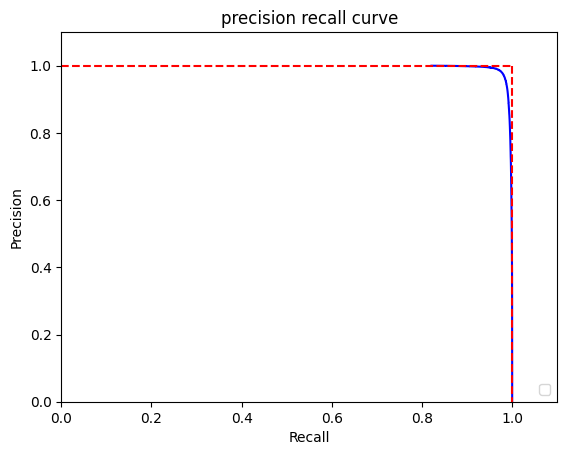

In [39]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(cv_true_labels, cv_predicted_labels)


# method I: plt
import matplotlib.pyplot as plt
plt.title('precision recall curve')
plt.plot(precision, recall, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 1],'r--')
plt.plot([1, 1], [1, 0],'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

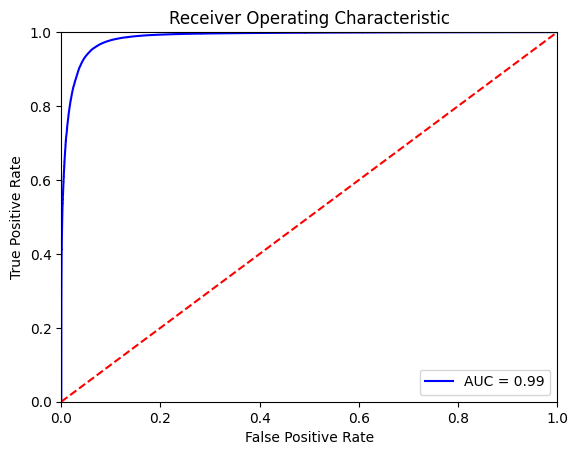

In [40]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(cv_true_labels, cv_predicted_labels)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
# Next we will evaluate the feature importance of the XGBoost model.
def evaluate_feature_importance(df_evaluate_feature_importance, md):
    feature_importance_average = [np.mean(i) for i in zip(*[md.get(model).feature_importances_ for model in md])]
    df_feature_importance = pd.DataFrame()
    df_feature_importance["Property"] = df_evaluate_feature_importance.columns
    df_feature_importance["Average_importance"] = feature_importance_average
    print(df_feature_importance.sort_values(by="Average_importance", ascending=False).head(50))

evaluate_feature_importance(df_evaluate_feature_importance=X_train_val.copy(), md=model_dict)

                                             Property  Average_importance
0                                      recount3_score            0.407085
3            recount3_near_start_ss_with_better_score            0.109644
4                                   MaxEntScan_end_ss            0.080491
2                             nearest_alt_end_ss_dist            0.047254
1                           nearest_alt_start_ss_dist            0.043739
5                                 MaxEntScan_start_ss            0.040836
24                                    phastCons_score            0.035386
6           repeat_features_start_site_Tandem repeats            0.027046
11            repeat_features_end_site_Tandem repeats            0.026666
17                                                chr            0.017694
26                                       phyloP_score            0.016199
10             recount3_near_end_ss_with_better_score            0.013855
21     repeat_features_start_site_Type

In [ ]:
import pickle
file_name = "model/temp_model.pkl"

# save
pickle.dump(model_dict[0], open(file_name, "wb")) # FIXME TEMPORARY THE FINAL ONE SHOULD TRAIN ON ALL DATA

# SHAP analysis

In [ ]:
import shap

X_train_sample = X_train.sample(frac=0.005, random_state=1)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(model_dict[0])
shap_values = explainer.shap_values(X_train_sample)

In [ ]:
shap.plots.waterfall(explainer(X_train_sample)[0])

In [ ]:
shap.dependence_plot(1, shap_values, X_train_sample, show=False)

ax = plt.gca()
ax.set_xlim(0, 100000)
plt.show()

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train_sample)

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train_sample, plot_type="bar")

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_train_sample.iloc[1,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:,:], X_train_sample.iloc[:,:])

In [ ]:
# # PREVIOUS code - archived
# shap.force_plot(shap_values[:,:,1].base_values, shap_values[5,:,1].values, X_train_sample.iloc[5,:], feature_names=X_train.columns) # single
# shap.force_plot(shap_values[:,:,1].base_values, shap_values[:,:,1].values, X_train_sample.iloc[:,:], feature_names=X_train.columns) # all